In [1]:
import tensorflow as tf
import os
import numpy as np
from tensorflow import keras

from IPython import display
from tqdm import tqdm
import matplotlib.pyplot as plt

In [38]:
IMAGE_SIZE = (32,32)
BATCH_SIZE = 32

In [39]:
def map_image(path):
    raw = tf.io.read_file(path)
    image = tf.io.decode_jpeg(raw, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = image / 255.0
    return image

In [40]:
filename_dataset = tf.data.Dataset.list_files('/kaggle/input/casiawebface-dataset-crop/CASIA-WebFace_crop/*.jpg')
image_dataset = filename_dataset.map(map_image)
image_dataset = image_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [143]:
new_size = int(len(image_dataset) * 0.6)
image_dataset_short = image_dataset.take(new_size)

In [120]:
def plot_results(images, n_cols=None):
    '''visualizes fake images'''
    display.clear_output(wait=False)

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))

    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [121]:
# random_normal_dimensions = 32

def create_generator(random_normal_dimensions):
    generator = keras.models.Sequential([
    keras.layers.Dense(4 * 4 * 128, activation = keras.layers.LeakyReLU(0.1),
                       input_shape = (random_normal_dimensions,)),
    keras.layers.Reshape((4, 4, 128)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2DTranspose(64, kernel_size = 5, strides = 2,
                                 padding = 'same', activation = keras.layers.LeakyReLU(0.2)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2DTranspose(128, kernel_size = 5, strides = 2,
                                 padding = 'same', activation = keras.layers.LeakyReLU(0.2)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2DTranspose(64, kernel_size = 5, strides = 2,
                                 padding = 'same', activation = keras.layers.LeakyReLU(0.2)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(3, kernel_size = 5, strides = 1,
                                 padding = 'same', activation = 'tanh')
    ])
    return generator

In [122]:
def residual_block(x, filters, kernel_size=3, strides=1):
    # Save input for the residual connection
    shortcut = x
    
    # First Conv2DTranspose layer
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    
    # Second Conv2DTranspose layer
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Residual connection: add the input to the output of the two Conv layers
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    
    return x

def residual_generator(random_normal_dimensions):
    # Fully connected layer to reshape into 4x4x128
    input = tf.keras.layers.Input(shape=(random_normal_dimensions,))
    x = tf.keras.layers.Dense(4 * 4 * 128)(input)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.Reshape((4, 4, 128))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # First transpose convolution to 8x8
    x = tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Residual Block 1
    x = residual_block(x, filters=64, kernel_size=5)
    
    # Second transpose convolution to 16x16
    x = tf.keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Residual Block 2
    x = residual_block(x, filters=128, kernel_size=5)

    # Third transpose convolution to 32x32
    x = tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Residual Block 3
    x = residual_block(x, filters=64, kernel_size=5)

    # Final transpose convolution to generate the 32x32x3 output
    output = tf.keras.layers.Conv2DTranspose(3, kernel_size=5, strides=1, padding='same', activation='tanh')(x)

    # Create model
    generator = tf.keras.models.Model(input, output)
    
    return generator

In [132]:
def discriminator_residual_block(x, filters, kernel_size, strides):
    shortcut = x
    
    # Conv block 1
    x = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same' )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # Conv block 2
    x = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # Residual Connection
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    return x

def residual_discriminator():
    inputs = tf.keras.layers.Input(shape=(32,32,3))
    x = tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # Residual Block 1
    x = discriminator_residual_block(x, filters=128, kernel_size=5, strides=2)
    
    # Residual Block 2
    x = discriminator_residual_block(x, filters=64, kernel_size=5, strides=2)
    
    # Residual Block 3
    x = discriminator_residual_block(x, filters=32, kernel_size=5, strides=2)
    
    x = keras.layers.Flatten()(x)
    output = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
        
    discriminator = tf.keras.models.Model(input, output)

    return discriminator

def create_discriminator():
    discriminator = keras.models.Sequential([
        keras.layers.Conv2D(64, kernel_size = 5, strides = 2, padding = 'same',
                            activation = keras.layers.LeakyReLU(0.2),
                            input_shape = (32, 32, 3)),
        keras.layers.Dropout(0.3),

        keras.layers.Conv2D(128, kernel_size = 5, strides = 2, padding = 'same',
                            activation = keras.layers.LeakyReLU(0.2)),
        keras.layers.Dropout(0.3),

        keras.layers.Flatten(),
        keras.layers.Dense(1, activation = 'sigmoid')
    ])
    
    return discriminator


In [138]:
generator = create_generator(random_normal_dimensions=32)
discriminator = create_discriminator()

gan = tf.keras.Sequential([generator, discriminator])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [139]:
def train_step(inputs, loss_obj, optimizer, model):
    input1, input2 = inputs
    
    with tf.GradientTape() as tape:
        predictions = model(input1)
        loss = loss_obj(input2, predictions)
        
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    return loss

def train_batch(real_images, random_normal_dimensions, compute_discriminator_loss, discriminator_opt, 
                discriminator, compute_generator_loss, generator_opt, gan):
            
    real_batch_size = real_images.shape[0]

    noise = tf.random.normal(shape=[real_batch_size, random_normal_dimensions])
    fake_images = generator(noise)

    mixed_images = tf.concat([fake_images, real_images], axis=0)
    discriminator_labels = tf.constant([[0.]] * real_batch_size + [[1.]] * real_batch_size)
    discriminator.trainable = True

    train_step((mixed_images, discriminator_labels), 
                             compute_discriminator_loss, discriminator_opt, 
                             discriminator)

    noise = tf.random.normal([real_batch_size, random_normal_dimensions])
    generator_labels = tf.constant([[1.]] * real_batch_size)
    discriminator.trainable = False

    train_step((noise, generator_labels), 
                         compute_generator_loss, generator_opt, 
                         gan)
    return fake_images


In [140]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
    random_normal_dimensions=32
    
    compute_generator_loss = tf.keras.losses.BinaryCrossentropy()
    compute_discriminator_loss = tf.keras.losses.BinaryCrossentropy()

    generator_opt = tf.keras.optimizers.RMSprop()
    discriminator_opt = tf.keras.optimizers.RMSprop()

    generator, discriminator = gan.layers

    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for real_images in tqdm(dataset):
            fake_images = train_batch(real_images, random_normal_dimensions, compute_discriminator_loss, discriminator_opt, 
                discriminator, compute_generator_loss, generator_opt, gan)

        plot_results(fake_images, 16)
        plt.show()
    
    return fake_images


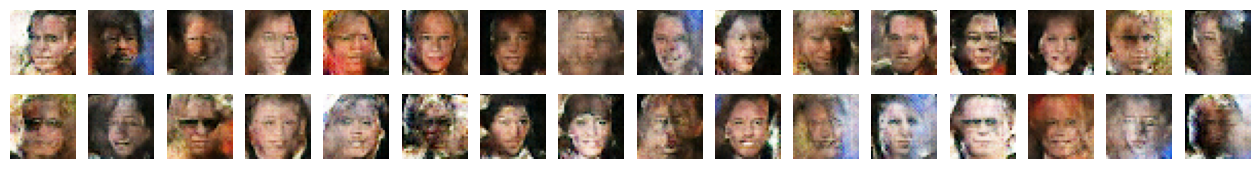

In [144]:
EPOCHS = 4
random_normal_dimensions = 32

fake_images = train_gan(gan, image_dataset_short, random_normal_dimensions, EPOCHS)